# Laboratorium 10 - Równania różniczkowe zwyczajne – część II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve, minimize
import pandas as pd


plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

#### Definicja układu równań Lotki-Volterry

In [2]:
def lotka_volterra(variables, t, alpha1, beta1, alpha2, beta2):
    x, y = variables
    dxdt = x * (alpha1 - beta1 * y)
    dydt = y * (-alpha2 + beta2 * x)
    return [dxdt, dydt]


x0 = 20
y0 = 20
initial_conditions = [x0, y0]


alpha1 = 1
beta1 = 0.1
alpha2 = 0.5
beta2 = 0.02
params = (alpha1, beta1, alpha2, beta2)


t_start = 0
t_end = 80
dt = 0.01
time_points = np.arange(t_start, t_end, dt)

#### Jawna Metoda Eulera

In [3]:
def explicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        dxdt, dydt = func([x[i], y[i]], t_points[i], *args)
        x[i + 1] = x[i] + dt * dxdt
        y[i + 1] = y[i] + dt * dydt
    return x, y


x_euler_exp, y_euler_exp = explicit_euler(
    lotka_volterra, initial_conditions, time_points, params
)


#### Niejawna Metoda Eulera
Wymaga rozwiązania nieliniowego układu równań w każdym kroku. Użyjemy `fsolve`.



In [4]:
def implicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        current_x, current_y = x[i], y[i]

        def equations_to_solve(vars_next):
            x_next, y_next = vars_next
            dxdt_next, dydt_next = func([x_next, y_next], t_points[i + 1], *args)
            eq1 = x_next - current_x - dt * dxdt_next
            eq2 = y_next - current_y - dt * dydt_next
            return [eq1, eq2]

        solution = fsolve(equations_to_solve, [current_x, current_y])
        x[i + 1], y[i + 1] = solution
    return x, y


try:
    x_euler_imp, y_euler_imp = implicit_euler(
        lotka_volterra, initial_conditions, time_points, params
    )
except Exception as e:
    print(f"Błąd podczas obliczeń niejawnej metody Eulera: {e}")
    print(
        "Spróbuj zmniejszyć dt lub zaimplementować inny solver dla układu nieliniowego."
    )
    x_euler_imp, y_euler_imp = (
        np.full_like(time_points, np.nan),
        np.full_like(time_points, np.nan),
    )

#### Półjawna Metoda Eulera
 Użyjemy wersji:
 $x_{n+1} = x_n + h_n f(x_n, y_{n+1})$
 $y_{n+1} = y_n + h_n g(x_n, y_{n+1})$

 Z drugiego równania możemy wyliczyć $y_{n+1}$ (jeśli $y_n$ i $g(x_n, y_{n+1})$ są odpowiednie), a potem $x_{n+1}$.

 Model Lotki-Volterry:
 $x_{n+1} = x_n + h_n \cdot x_n (\alpha_1 - \beta_1 y_{n+1})$
 $y_{n+1} = y_n + h_n \cdot y_{n+1} (-\alpha_2 + \beta_2 x_n)$

 Z drugiego równania:
 $y_{n+1} (1 - h_n (-\alpha_2 + \beta_2 x_n)) = y_n$
 $y_{n+1} = y_n / (1 + h_n \alpha_2 - h_n \beta_2 x_n)$

 A potem $x_{n+1}$:
 $x_{n+1} = x_n + h_n \cdot x_n (\alpha_1 - \beta_1 y_{n+1})$


In [5]:
def semi_implicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions
    alpha1, beta1, alpha2, beta2 = args

    for i in range(num_steps - 1):
        denominator_y = 1 + dt * alpha2 - dt * beta2 * x[i]
        if denominator_y == 0:
            y[i + 1] = np.nan
        else:
            y[i + 1] = y[i] / denominator_y

        x[i + 1] = x[i] + dt * x[i] * (alpha1 - beta1 * y[i + 1])

        x[i + 1] = max(0, x[i + 1])
        y[i + 1] = max(0, y[i + 1])

    return x, y


x_euler_semi_imp, y_euler_semi_imp = semi_implicit_euler(
    lotka_volterra, initial_conditions, time_points, params
)

#### Metoda Rungego-Kutty czwartego rzędu (RK4)

In [6]:
def rk4_solver(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        current_vars = [x[i], y[i]]

        k1_x, k1_y = func(current_vars, t_points[i], *args)

        vars_k2 = [current_vars[0] + dt * k1_x / 2, current_vars[1] + dt * k1_y / 2]
        k2_x, k2_y = func(vars_k2, t_points[i] + dt / 2, *args)

        vars_k3 = [current_vars[0] + dt * k2_x / 2, current_vars[1] + dt * k2_y / 2]
        k3_x, k3_y = func(vars_k3, t_points[i] + dt / 2, *args)

        vars_k4 = [current_vars[0] + dt * k3_x, current_vars[1] + dt * k3_y]
        k4_x, k4_y = func(vars_k4, t_points[i] + dt, *args)

        x[i + 1] = current_vars[0] + dt / 6 * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
        y[i + 1] = current_vars[1] + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)

        x[i + 1] = max(0, x[i + 1])
        y[i + 1] = max(0, y[i + 1])

    return x, y


x_rk4, y_rk4 = rk4_solver(lotka_volterra, initial_conditions, time_points, params)

solution_odeint = odeint(lotka_volterra, initial_conditions, time_points, args=params)
x_odeint, y_odeint = solution_odeint[:, 0], solution_odeint[:, 1]

#### Wykresy liczebności populacji w zależności od czasu

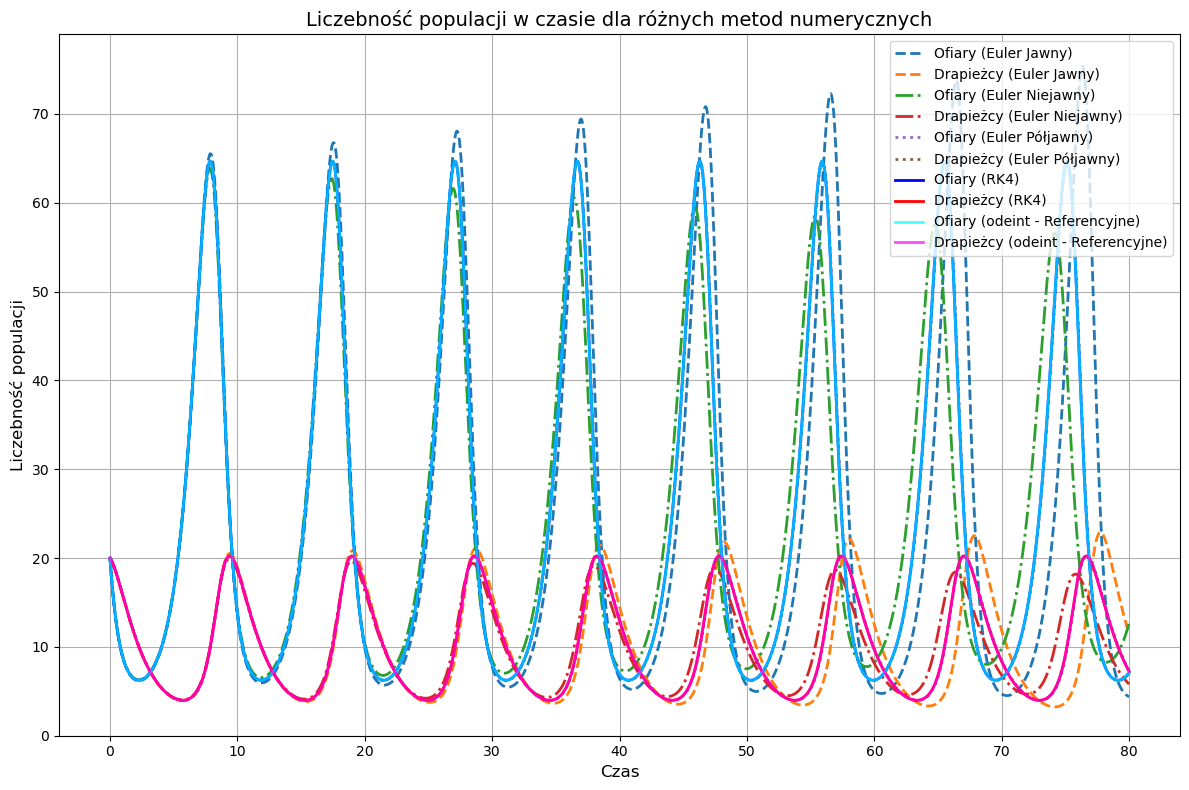

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(time_points, x_euler_exp, label="Ofiary (Euler Jawny)", linestyle="--")
plt.plot(time_points, y_euler_exp, label="Drapieżcy (Euler Jawny)", linestyle="--")

if not np.all(np.isnan(x_euler_imp)):
    plt.plot(time_points, x_euler_imp, label="Ofiary (Euler Niejawny)", linestyle="-.")
    plt.plot(
        time_points, y_euler_imp, label="Drapieżcy (Euler Niejawny)", linestyle="-."
    )

plt.plot(time_points, x_euler_semi_imp, label="Ofiary (Euler Półjawny)", linestyle=":")
plt.plot(
    time_points, y_euler_semi_imp, label="Drapieżcy (Euler Półjawny)", linestyle=":"
)

plt.plot(time_points, x_rk4, label="Ofiary (RK4)", color="blue")
plt.plot(time_points, y_rk4, label="Drapieżcy (RK4)", color="red")

plt.plot(
    time_points,
    x_odeint,
    label="Ofiary (odeint - Referencyjne)",
    color="cyan",
    alpha=0.7,
)
plt.plot(
    time_points,
    y_odeint,
    label="Drapieżcy (odeint - Referencyjne)",
    color="magenta",
    alpha=0.7,
)


plt.title("Liczebność populacji w czasie dla różnych metod numerycznych")
plt.xlabel("Czas")
plt.ylabel("Liczebność populacji")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

#### Portret fazowy

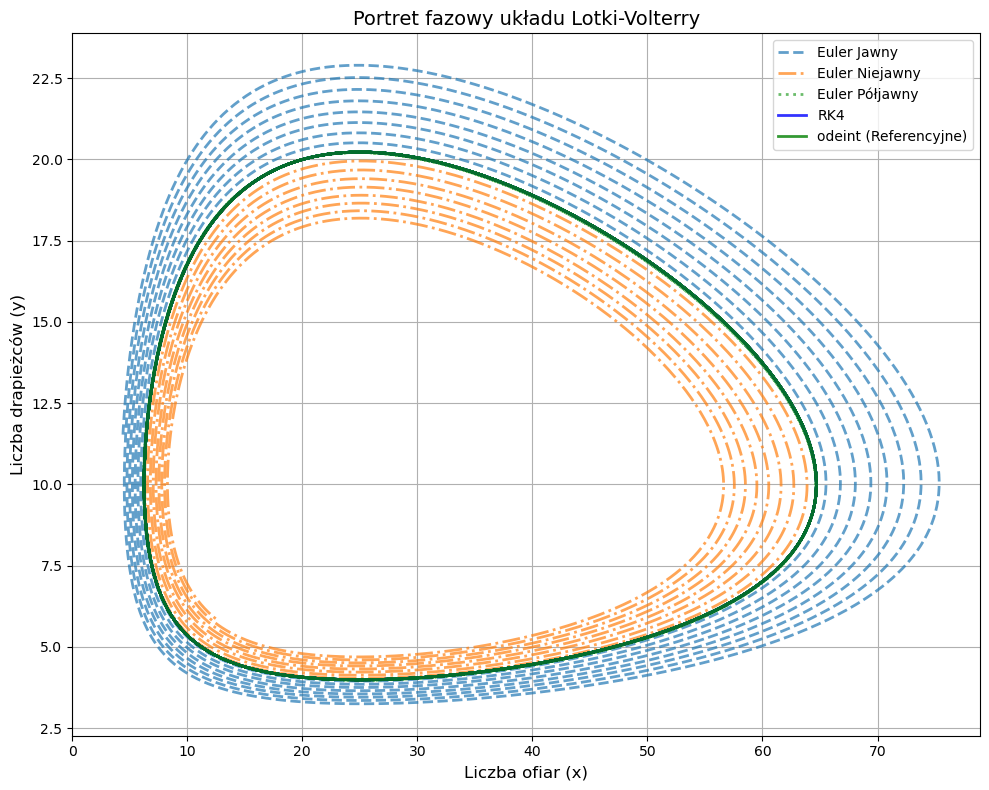

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(x_euler_exp, y_euler_exp, label="Euler Jawny", linestyle="--", alpha=0.7)
if not np.all(np.isnan(x_euler_imp)):
    plt.plot(
        x_euler_imp, y_euler_imp, label="Euler Niejawny", linestyle="-.", alpha=0.7
    )
plt.plot(
    x_euler_semi_imp, y_euler_semi_imp, label="Euler Półjawny", linestyle=":", alpha=0.7
)
plt.plot(x_rk4, y_rk4, label="RK4", color="blue", alpha=0.8)
plt.plot(x_odeint, y_odeint, label="odeint (Referencyjne)", color="green", alpha=0.8)

plt.title("Portret fazowy układu Lotki-Volterry")
plt.xlabel("Liczba ofiar (x)")
plt.ylabel("Liczba drapieżców (y)")
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.tight_layout()
plt.show()

Portret fazowy składa się z krzywych, które reprezentują różne warunki początkowe. Są one zamknięte, ponieważ zmiany liczebności zwierząt zachodzą cyklicznie. Zmiany można podzielić na etapy:

 * Kiedy liczba ofiar jest wysoka, drapieżcy mają dużo pożywienia, ich populacja rośnie, a populacja ofiar maleje z powodu zwiększonego drapieżnictwa.
 * Kiedy liczba ofiar spada, drapieżcy mają mniej pożywienia, ich populacja maleje, co pozwala populacji ofiar się odbudować.
 * Wzrost liczby ofiar ponownie prowadzi do wzrostu liczby drapieżców, zamykając cykl.

 Punkt centralny jest punktem równowagi, w którym potencjalnie liczby osobników nie zmieniałyby się.


 Rozwiązujemy układ równań:
 x(alpha1 - beta1 * y) = 0
 y(-alpha2 + beta2 * x) = 0

Rozwiązywanie punktów stacjonarnych:
Punkt stacjonarny 1: (0, 0)
Punkt stacjonarny 2: (25.00, 10.00)
Dla podanych parametrów: x_eq = 0.5/0.02 = 25.00, y_eq = 1/0.1 = 10.00


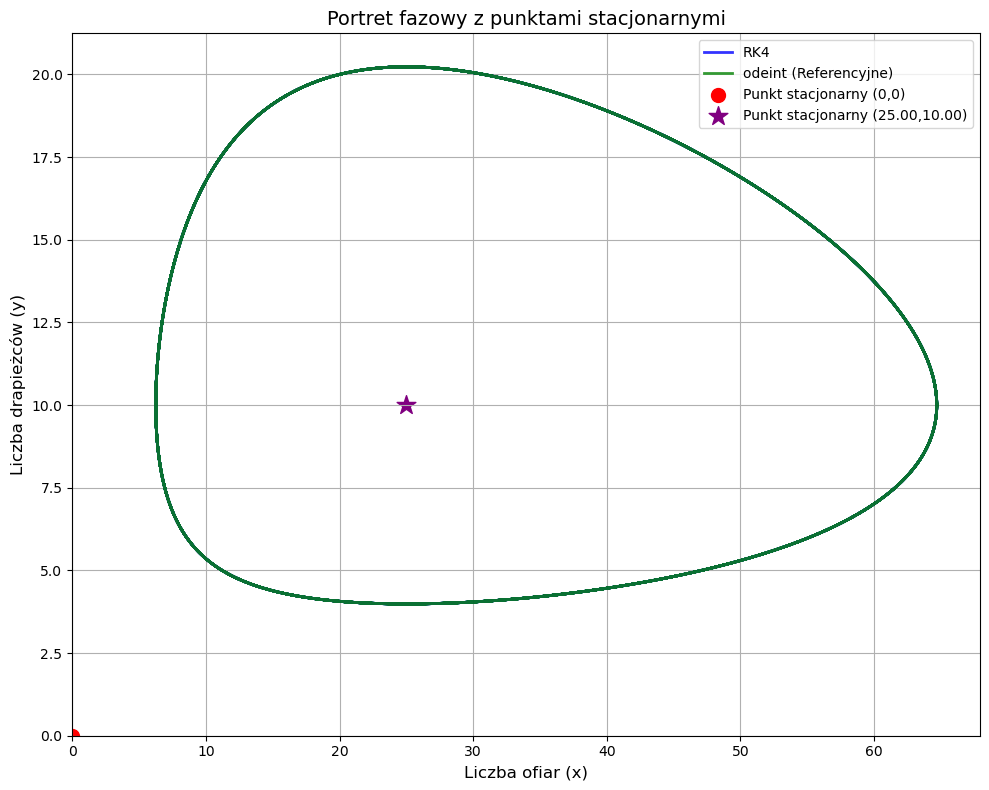

In [9]:
print("Rozwiązywanie punktów stacjonarnych:")

# Przypadek 1: x = 0
# Wtedy 0 * (alpha1 - beta1 * y) = 0 (zawsze prawda)
# y(-alpha2 + beta2 * 0) = 0  =>  y * (-alpha2) = 0
# Ponieważ alpha2 > 0, to y musi być 0.
# Punkt stacjonarny 1: (0, 0)
print(f"Punkt stacjonarny 1: (0, 0)")

# Przypadek 2: y = alpha1 / beta1
# Wtedy x(alpha1 - beta1 * (alpha1 / beta1)) = x(alpha1 - alpha1) = 0 (zawsze prawda)
# A z drugiego równania:
# y(-alpha2 + beta2 * x) = 0
# Ponieważ y != 0 (bo inaczej wracamy do (0,0)), to (-alpha2 + beta2 * x) musi być 0.
# -alpha2 + beta2 * x = 0  =>  x = alpha2 / beta2

x_equilibrium = alpha2 / beta2
y_equilibrium = alpha1 / beta1

print(f"Punkt stacjonarny 2: ({x_equilibrium:.2f}, {y_equilibrium:.2f})")
print(
    f"Dla podanych parametrów: x_eq = {alpha2}/{beta2} = {x_equilibrium:.2f}, y_eq = {alpha1}/{beta1} = {y_equilibrium:.2f}"
)

# Dodanie punktów stacjonarnych do wykresu fazowego
plt.figure(figsize=(10, 8))
plt.plot(x_rk4, y_rk4, label="RK4", color="blue", alpha=0.8)
plt.plot(x_odeint, y_odeint, label="odeint (Referencyjne)", color="green", alpha=0.8)
plt.scatter(0, 0, color="red", marker="o", s=100, label="Punkt stacjonarny (0,0)")
plt.scatter(
    x_equilibrium,
    y_equilibrium,
    color="purple",
    marker="*",
    s=200,
    label=f"Punkt stacjonarny ({x_equilibrium:.2f},{y_equilibrium:.2f})",
)

plt.title("Portret fazowy z punktami stacjonarnymi")
plt.xlabel("Liczba ofiar (x)")
plt.ylabel("Liczba drapieżców (y)")
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

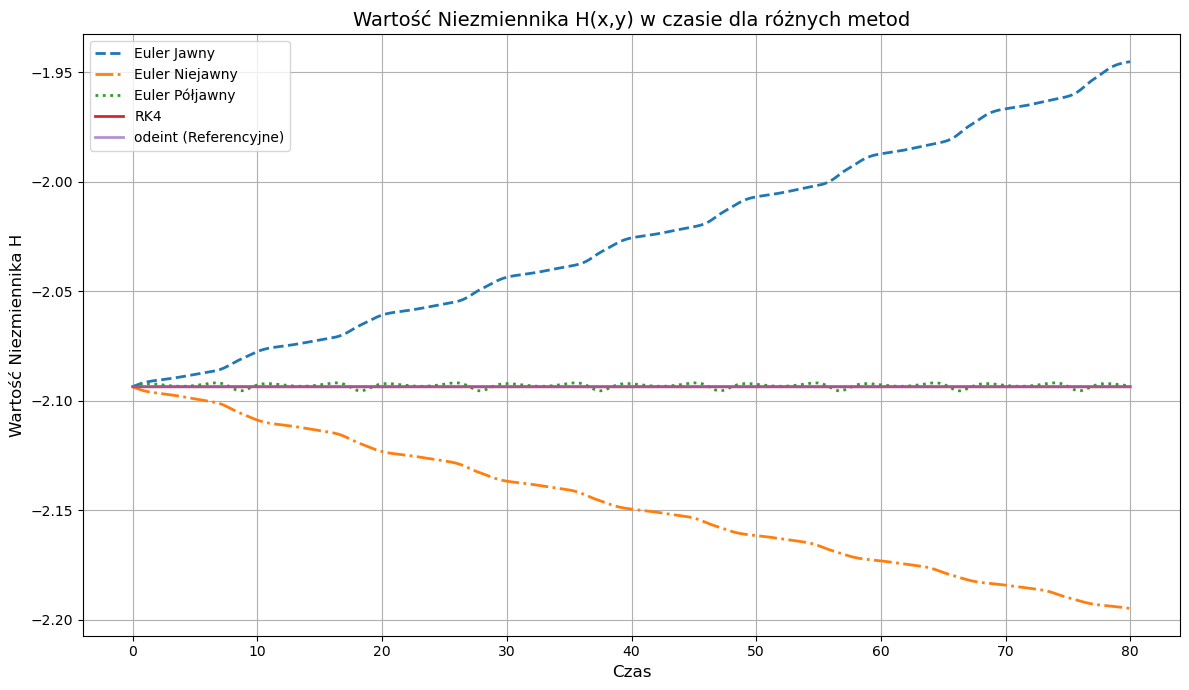

In [10]:
def calculate_invariant(x_vals, y_vals, alpha1, beta1, alpha2, beta2):
    x_safe = np.maximum(x_vals, 1e-9)
    y_safe = np.maximum(y_vals, 1e-9)
    return (
        beta2 * x_safe
        + beta1 * y_safe
        - alpha2 * np.log(x_safe)
        - alpha1 * np.log(y_safe)
    )


H_euler_exp = calculate_invariant(x_euler_exp, y_euler_exp, *params)
if not np.all(np.isnan(x_euler_imp)):
    H_euler_imp = calculate_invariant(x_euler_imp, y_euler_imp, *params)
else:
    H_euler_imp = np.full_like(time_points, np.nan)

H_euler_semi_imp = calculate_invariant(x_euler_semi_imp, y_euler_semi_imp, *params)
H_rk4 = calculate_invariant(x_rk4, y_rk4, *params)
H_odeint = calculate_invariant(x_odeint, y_odeint, *params)

plt.figure(figsize=(12, 7))
plt.plot(time_points, H_euler_exp, label="Euler Jawny", linestyle="--")
if not np.all(np.isnan(H_euler_imp)):
    plt.plot(time_points, H_euler_imp, label="Euler Niejawny", linestyle="-.")
plt.plot(time_points, H_euler_semi_imp, label="Euler Półjawny", linestyle=":")
plt.plot(time_points, H_rk4, label="RK4")
plt.plot(time_points, H_odeint, label="odeint (Referencyjne)", alpha=0.7)

plt.title("Wartość Niezmiennika H(x,y) w czasie dla różnych metod")
plt.xlabel("Czas")
plt.ylabel("Wartość Niezmiennika H")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

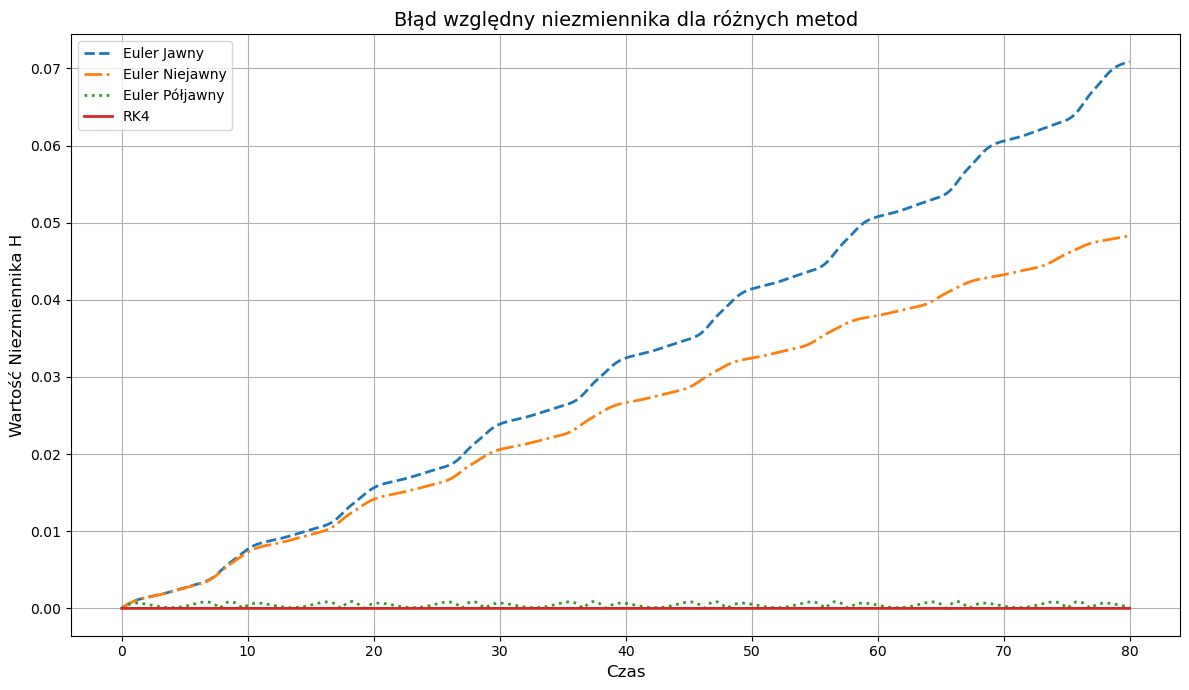

In [11]:
H_euler_exp_wzg = [
    abs((H_euler_exp[i] - H_odeint[i]) / H_odeint[i]) for i in range(len(H_odeint))
]
H_euler_imp_wzg = [
    abs((H_euler_imp[i] - H_odeint[i]) / H_odeint[i]) for i in range(len(H_odeint))
]
H_euler_semi_imp_wzg = [
    abs((H_euler_semi_imp[i] - H_odeint[i]) / H_odeint[i]) for i in range(len(H_odeint))
]
H_rk4_wzg = [abs((H_rk4[i] - H_odeint[i]) / H_odeint[i]) for i in range(len(H_odeint))]
plt.figure(figsize=(12, 7))
plt.plot(time_points, H_euler_exp_wzg, label="Euler Jawny", linestyle="--")
if not np.all(np.isnan(H_euler_imp_wzg)):
    plt.plot(time_points, H_euler_imp_wzg, label="Euler Niejawny", linestyle="-.")
plt.plot(time_points, H_euler_semi_imp_wzg, label="Euler Półjawny", linestyle=":")
plt.plot(time_points, H_rk4_wzg, label="RK4")

plt.title("Błąd względny niezmiennika dla różnych metod")
plt.xlabel("Czas")
plt.ylabel("Wartość Niezmiennika H")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Analiza zachowania niezmiennika:
 W teorii, dla dokładnego rozwiązania analitycznego modelu Lotki-Volterry, wartość niezmiennika $H(x,y)$ powinna być stała w czasie. W praktyce, metody numeryczne wprowadzają błędy, które powodują dryf tej wartości.

 * Metoda Eulera Jawna: Wykazuje największy dryf niezmiennika, co świadczy o jej niższej dokładności i braku zachowania objętości w przestrzeni fazowej. Niezmiennik zwykle rośnie lub maleje monotonicznie.
 * Metoda Eulera Niejawna/Półjawna: Mogą wykazywać lepsze zachowanie niezmiennika w pewnych reżimach, ale nadal nie są doskonałe. Półjawna metoda Eulera często zachowuje się lepiej niż jawna.
 * Metoda RK4: Zdecydowanie najlepiej zachowuje wartość niezmiennika, wykazując jedynie niewielkie oscylacje wokół średniej wartości. Jest to oczekiwane, ponieważ RK4 jest metodą wyższego rzędu, która ma mniejszy błąd lokalny.

 Ogólnie, stopień, w jakim niezmiennik jest zachowany, jest dobrym wskaźnikiem dokładności i stabilności metody numerycznej.

In [12]:
try:
    data = pd.read_csv(
        "LynxHare.txt", sep="\s+", header=None, names=["Year", "Hare", "Lynx"]
    )
except FileNotFoundError:
    print(
        "Plik 'LynxHare.txt' nie został znaleziony. Upewnij się, że znajduje się w tym samym katalogu."
    )


years = data["Year"].values.astype(np.double)
hare_obs = data["Hare"].values.astype(np.double)
lynx_obs = data["Lynx"].values.astype(np.double)

t_obs = years - years[0]
dt_obs = t_obs[1] - t_obs[0]

if not np.allclose(np.diff(t_obs), dt_obs):
    print(
        "Ostrzeżenie: Krok czasowy w danych nie jest stały. Może to wpłynąć na dokładność symulacji."
    )

initial_conditions_obs = [hare_obs[0], lynx_obs[0]]


def simulate_lotka_volterra(theta, initial_cond, t_points):
    alpha1, alpha2, beta1, beta2 = theta
    alpha1 = max(1e-9, alpha1)
    alpha2 = max(1e-9, alpha2)
    beta1 = max(1e-9, beta1)
    beta2 = max(1e-9, beta2)

    sim_x, sim_y = rk4_solver(
        lotka_volterra, initial_cond, t_points, (alpha1, beta1, alpha2, beta2)
    )
    return sim_x, sim_y


initial_theta = [
    alpha1,
    alpha2,
    beta1,
    beta2,
]

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/h3/3x1lb4qj61b0qgxrypy_9xq40000gn/T/ipykernel_49858/2702461176.py:3: SyntaxWarning: invalid escape sequence '\s'
  "LynxHare.txt", sep="\s+", header=None, names=["Year", "Hare", "Lynx"]


 #### Funkcja kosztu: Suma Kwadratów Reszt (RSS)



Minimalizacja funkcji kosztu: Suma Kwadratów Reszt (RSS)
Optimization terminated successfully.
         Current function value: 181370.403846
         Iterations: 247
         Function evaluations: 414
Oszacowane parametry (RSS): α1=1.1166, α2=0.1036, β1=-0.0028, β2=-0.0001


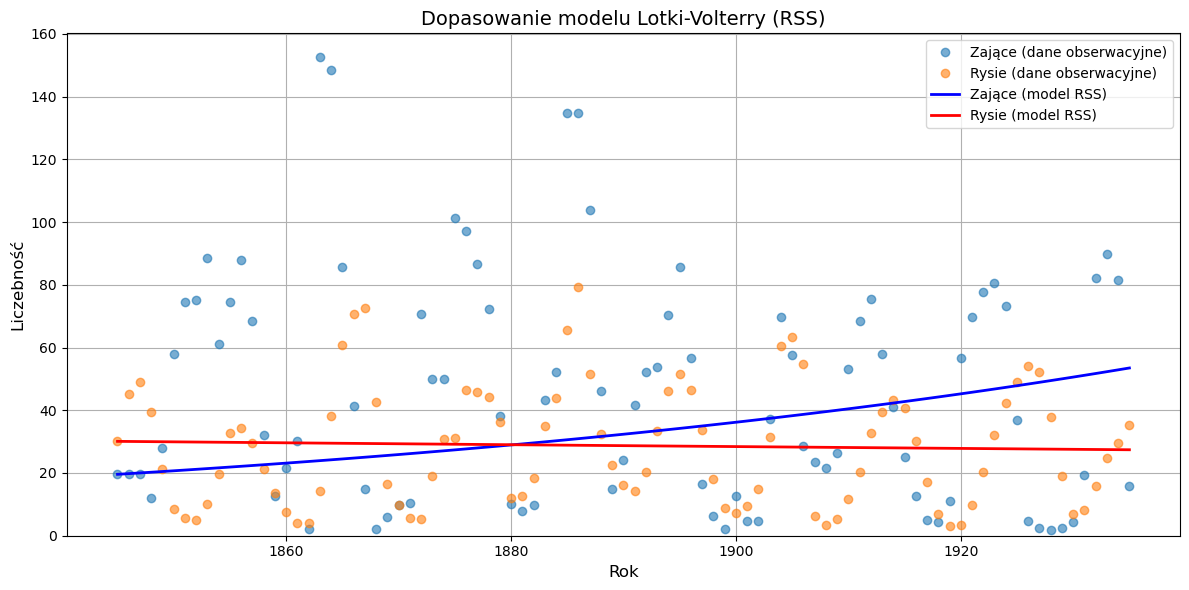

In [13]:
def cost_function_rss(theta, initial_cond, t_points, h_obs, l_obs):
    sim_h, sim_l = simulate_lotka_volterra(theta, initial_cond, t_points)

    min_len = min(len(sim_h), len(h_obs))

    rss = np.sum((h_obs[:min_len] - sim_h[:min_len]) ** 2) + np.sum(
        (l_obs[:min_len] - sim_l[:min_len]) ** 2
    )
    return rss


print("Minimalizacja funkcji kosztu: Suma Kwadratów Reszt (RSS)")
result_rss = minimize(
    cost_function_rss,
    initial_theta,
    args=(initial_conditions_obs, time_points, hare_obs, lynx_obs),
    method="Nelder-Mead",
    options={"disp": True, "maxiter": 5000},
)

estimated_theta_rss = result_rss.x
print(
    f"Oszacowane parametry (RSS): α1={estimated_theta_rss[0]:.4f}, α2={estimated_theta_rss[1]:.4f}, β1={estimated_theta_rss[2]:.4f}, β2={estimated_theta_rss[3]:.4f}"
)

sim_hare_rss, sim_lynx_rss = simulate_lotka_volterra(
    estimated_theta_rss, initial_conditions_obs, time_points
)

plt.figure(figsize=(12, 6))
plt.plot(years, hare_obs, "o", label="Zające (dane obserwacyjne)", alpha=0.6)
plt.plot(years, lynx_obs, "o", label="Rysie (dane obserwacyjne)", alpha=0.6)
plt.plot(
    years, sim_hare_rss[: len(years)], "-", label="Zające (model RSS)", color="blue"
)
plt.plot(years, sim_lynx_rss[: len(years)], "-", label="Rysie (model RSS)", color="red")
plt.title("Dopasowanie modelu Lotki-Volterry (RSS)")
plt.xlabel("Rok")
plt.ylabel("Liczebność")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

#### Funkcja kosztu oparta na funkcji wiarygodności (Poisson-like)


Minimalizacja funkcji kosztu: Oparta na funkcji wiarygodności (Poisson-like)
Optimization terminated successfully.
         Current function value: -17213.491496
         Iterations: 172
         Function evaluations: 298
Oszacowane parametry (Likelihood): α1=1.2317, α2=0.1048, β1=-0.0371, β2=-0.0004


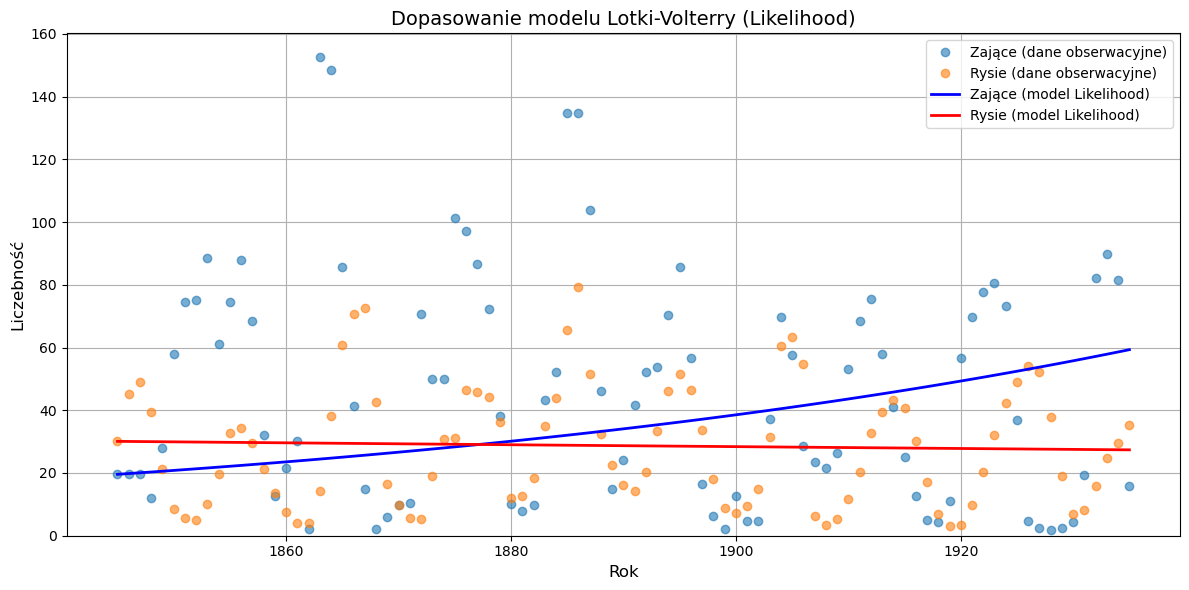

In [14]:
def cost_function_likelihood(theta, initial_cond, t_points, h_obs, l_obs):
    sim_h, sim_l = simulate_lotka_volterra(theta, initial_cond, t_points)

    min_len = min(len(sim_h), len(h_obs))

    sim_h_safe = np.maximum(sim_h[:min_len], 1e-9)
    sim_l_safe = np.maximum(sim_l[:min_len], 1e-9)

    cost = (
        -np.sum(l_obs[:min_len] * np.log(sim_l_safe))
        - np.sum(h_obs[:min_len] * np.log(sim_h_safe))
        + np.sum(sim_l_safe)
        + np.sum(sim_h_safe)
    )
    return cost


print("\nMinimalizacja funkcji kosztu: Oparta na funkcji wiarygodności (Poisson-like)")
result_likelihood = minimize(
    cost_function_likelihood,
    initial_theta,
    args=(initial_conditions_obs, time_points, hare_obs, lynx_obs),
    method="Nelder-Mead",
    options={"disp": True, "maxiter": 5000},
)

estimated_theta_likelihood = result_likelihood.x
print(
    f"Oszacowane parametry (Likelihood): α1={estimated_theta_likelihood[0]:.4f}, α2={estimated_theta_likelihood[1]:.4f}, β1={estimated_theta_likelihood[2]:.4f}, β2={estimated_theta_likelihood[3]:.4f}"
)

sim_hare_likelihood, sim_lynx_likelihood = simulate_lotka_volterra(
    estimated_theta_likelihood, initial_conditions_obs, time_points
)

plt.figure(figsize=(12, 6))
plt.plot(years, hare_obs, "o", label="Zające (dane obserwacyjne)", alpha=0.6)
plt.plot(years, lynx_obs, "o", label="Rysie (dane obserwacyjne)", alpha=0.6)
plt.plot(
    years,
    sim_hare_likelihood[: len(years)],
    "-",
    label="Zające (model Likelihood)",
    color="blue",
)
plt.plot(
    years,
    sim_lynx_likelihood[: len(years)],
    "-",
    label="Rysie (model Likelihood)",
    color="red",
)
plt.title("Dopasowanie modelu Lotki-Volterry (Likelihood)")
plt.xlabel("Rok")
plt.ylabel("Liczebność")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [15]:
print("\n--- Podsumowanie Oszacowanych Parametrów ---")
print("Parametry początkowe (domyślne):")
print(f"  α1 = {alpha1:.4f}, α2 = {alpha2:.4f}, β1 = {beta1:.4f}, β2 = {beta2:.4f}")

print("\nOszacowane parametry (metoda RSS):")
print(
    f"  α1 = {estimated_theta_rss[0]:.4f}, α2 = {estimated_theta_rss[1]:.4f}, β1 = {estimated_theta_rss[2]:.4f}, β2 = {estimated_theta_rss[3]:.4f}"
)
print(f"  Wartość funkcji kosztu (RSS): {result_rss.fun:.4f}")

print("\nOszacowane parametry (metoda Likelihood):")
print(
    f"  α1 = {estimated_theta_likelihood[0]:.4f}, α2 = {estimated_theta_likelihood[1]:.4f}, β1 = {estimated_theta_likelihood[2]:.4f}, β2 = {estimated_theta_likelihood[3]:.4f}"
)
print(f"  Wartość funkcji kosztu (Likelihood): {result_likelihood.fun:.4f}")

print(
    "\nWizualizacje powyżej pokazują, jak dobrze modele dopasowały się do danych. Wartości parametrów mogą się różnić w zależności od wybranej funkcji kosztu oraz początkowego zgadnięcia."
)


--- Podsumowanie Oszacowanych Parametrów ---
Parametry początkowe (domyślne):
  α1 = 1.0000, α2 = 0.5000, β1 = 0.1000, β2 = 0.0200

Oszacowane parametry (metoda RSS):
  α1 = 1.1166, α2 = 0.1036, β1 = -0.0028, β2 = -0.0001
  Wartość funkcji kosztu (RSS): 181370.4038

Oszacowane parametry (metoda Likelihood):
  α1 = 1.2317, α2 = 0.1048, β1 = -0.0371, β2 = -0.0004
  Wartość funkcji kosztu (Likelihood): -17213.4915

Wizualizacje powyżej pokazują, jak dobrze modele dopasowały się do danych. Wartości parametrów mogą się różnić w zależności od wybranej funkcji kosztu oraz początkowego zgadnięcia.
